In [1]:
import pandas as pd
import numpy as np
from plotnine import *
import patsy
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, roc_curve, mean_squared_error, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from py_helper_functions import *

import warnings
warnings.filterwarnings('ignore')

# Import data

In [2]:
data = pd.read_csv('cs_bisnode_panel.csv')

In [3]:
data.head()

,comp_id,begin,end,COGS,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,gender,origin,nace_main,ind2,ind,urban_m,region_m,founded_date,exit_date,labor_avg
0,1001034.0,2005-01-01,2005-12-31,NaN,692.592590,7266.666504,7574.074219,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
1,1001034.0,2006-01-01,2006-12-31,NaN,603.703674,13122.222656,12211.111328,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
2,1001034.0,2007-01-01,2007-12-31,NaN,425.925934,8196.295898,7800.000000,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
3,1001034.0,2008-01-01,2008-12-31,NaN,300.000000,8485.185547,7781.481445,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
4,1001034.0,2009-01-01,2009-12-31,NaN,207.407410,5137.037109,15300.000000,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,0.083333


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287829 entries, 0 to 287828
Data columns (total 48 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   comp_id               287829 non-null  float64
 1   begin                 287829 non-null  object 
 2   end                   287829 non-null  object 
 3   COGS                  18257 non-null   float64
 4   amort                 279789 non-null  float64
 5   curr_assets           287698 non-null  float64
 6   curr_liab             287698 non-null  float64
 7   extra_exp             269300 non-null  float64
 8   extra_inc             269300 non-null  float64
 9   extra_profit_loss     270626 non-null  float64
 10  finished_prod         17485 non-null   float64
 11  fixed_assets          287698 non-null  float64
 12  inc_bef_tax           280392 non-null  float64
 13  intang_assets         287689 non-null  float64
 14  inventories           287698 non-null  float64
 15  

In [5]:
# drop variables with many NAs
data = data.drop(columns = ['COGS', 'finished_prod', 'net_dom_sales', 'net_exp_sales', 'wages', 'D'])
data = data.query('year != 2016')  # because third as many companies in 2016 as in earlier years in README.txt

# Label engineering

In [6]:
# Combine year(2005-2015) and comp_id, This will increase the number of entries in the table,
# because not every company will have complete data from year 2005 to 2015 before this operation.
data = data.set_index(['year','comp_id']).unstack(fill_value='toReplace').stack().reset_index()
# So only way I counld define it as Nan
data = data.replace('toReplace', np.nan)

In [7]:
# generate status_alive; if sales larger than zero and not-NA, then firm is alive
data['status_alive'] = ((False == data['sales'].isna()) & data['sales'] > 0).astype(int)

In [8]:
# target(fast growth): if there are sales in this year and also sales two years before,
# and the current sales is 120% of two years before 
# Status_in_two_year: data.groupby('comp_id')['status_alive'].shift(2)
# Sales_two_year_120%: ((data['sales'] / data.groupby('comp_id')['sales'].shift(2)) >= 1.2).astype(int)
data['sales_120_percent'] = ((data['sales'] / data.groupby('comp_id')['sales'].shift(2)) >= 1.2).astype(int)

data['fast_growth'] = ((data['status_alive'] == 1) & 
                       (data.groupby('comp_id')['status_alive'].shift(2) == 1) &
                       (data['sales_120_percent'] == 1)).astype(int)

In [9]:
data = data.query('year <= 2013')

In [10]:
data['fast_growth'].describe()

count    417708.000000
mean          0.096453
std           0.295211
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: fast_growth, dtype: float64

In [11]:
data['sales'].describe()

count    2.151190e+05
mean     4.860478e+05
std      3.885493e+06
min     -1.472559e+07
25%      5.344444e+03
50%      3.055555e+04
75%      1.083537e+05
max      1.110294e+08
Name: sales, dtype: float64

In [12]:
# sales missing many values
# sales process
data['sales']=np.where(data['sales'] < 0, 1, data['sales'])  # if sales < 0 output 1 else stay same

In [13]:
data = data.assign(
    # sales < 0 => 0  Nan => Nan
    ln_sales = np.where(data['sales'] > 0 , np.log(data['sales'] + 1e-10), (np.where(data['sales'].isna(),np.nan,0))), #NaN remain NaN
    sales_mil=data['sales']/1000000,
    sales_mil_log = np.where(data['sales'] > 0, np.log((data['sales']/1000000) + 1e-10) , (np.where(data['sales'].isna(),np.nan,0)))
)

In [14]:
# replace w 0 for new firms + add dummy to capture it
data['age'] = np.where(data['year'] - data['founded_year'] < 0, 0, data['year'] - data['founded_year'])

# new company or not 
data['new'] = np.where(((data['age'] <= 1) | (data['balsheet_notfullyear']==1)), 1 , (np.where(data['age'].isna(),np.nan,0))) 
data['new']=np.where(data['new'].isna(), 1, data['new'] )

In [15]:
data['new'].describe()

count    417708.000000
mean          0.660277
std           0.473616
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: new, dtype: float64

# Sample design

In [16]:
# look at cross section
data=data.query('year==2013 & status_alive == 1')
# look at firms below 10m euro revenues and above 1000 euros
data=data.query('sales_mil <= 10 & sales_mil >= 0.001')  # 1000eur - 10000000eur

In [17]:
data.fast_growth.describe()

count    21464.000000
mean         0.302320
std          0.459274
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: fast_growth, dtype: float64

# Feature engineering

In [18]:
# change some industry category codes
data['ind2_cat'] = data['ind2'].copy()
data['ind2_cat'] = np.where(data['ind2']>56, 60, data['ind2_cat'])
data['ind2_cat'] = np.where(data['ind2']<26, 20, data['ind2_cat'])
data['ind2_cat'] = np.where((data['ind2']<55) & (data['ind2']>35), 40, data['ind2_cat'])
data['ind2_cat'] = np.where(data['ind2']==31, 30, data['ind2_cat'])
data['ind2_cat'] = np.where(data['ind2'].isna(), 99, data['ind2_cat'])

In [19]:
data.groupby('ind2_cat').count()['comp_id']

ind2_cat
20.0       55
26.0     1050
27.0      636
28.0     1943
29.0      279
30.0      172
32.0      133
33.0     1950
40.0      219
55.0     2315
56.0    12456
60.0      251
99.0        5
Name: comp_id, dtype: int64

In [20]:
# Firm characteristics
data['age2'] = data['age'] ** 2
data['foreign_management'] = np.where(data['foreign'] >= 0.5, 1, np.where(data['foreign'].isna(), np.nan, 0))
data['gender_m'] = data['gender'].astype("category")
data['m_region_loc'] = data['region_m'].astype("category")

In [21]:
# look at more financial variables, create ratios
# assets can't be negative. Change them to 0 and add a flag.
data['flag_asset_problem'] = np.where(((data['intang_assets'] < 0) | (data['curr_assets'] < 0) | (data['fixed_assets'] < 0)), 1, 0)
data['flag_asset_problem'] = np.where(((data['intang_assets'].isna()) | (data['curr_assets'].isna()) | (data['fixed_assets'].isna())), np.nan, data['flag_asset_problem'])
data.groupby('flag_asset_problem').count()['comp_id']

flag_asset_problem
0.0    21449
1.0       14
Name: comp_id, dtype: int64

In [22]:
data['intang_assets'] = np.where(data['intang_assets'] < 0, 0, data['intang_assets'])
data['curr_assets'] = np.where(data['curr_assets'] < 0, 0, data['curr_assets'])
data['fixed_assets'] = np.where(data['fixed_assets'] < 0, 0, data['fixed_assets'])

In [23]:
# generate total assets
data['total_assets_bs'] = data['intang_assets'] + data['curr_assets'] + data['fixed_assets']
data['total_assets_bs'].describe()

count    2.146300e+04
mean     2.688416e+05
std      1.676639e+06
min      0.000000e+00
25%      7.231481e+03
50%      2.630000e+04
75%      1.035889e+05
max      1.325147e+08
Name: total_assets_bs, dtype: float64

In [24]:
pl_names = ['extra_exp','extra_inc',  'extra_profit_loss', 'inc_bef_tax' ,'inventories',
              'material_exp', 'profit_loss_year', 'personnel_exp']
bs_names = ['intang_assets', 'curr_liab', 'fixed_assets', 'liq_assets', 'curr_assets',
              'share_eq', 'subscribed_cap', 'tang_assets' ]

In [25]:
# divide all pl_names elements by sales and create new column for it
data[[col + '_pl' for col in pl_names]] = data[pl_names].div(data['sales'], axis='index')

In [26]:
# divide all bs_names elements by total_assets_bs and create new column for it
data[[col +'_bs' for col in bs_names]] =  data[bs_names].div(data['total_assets_bs'], axis='index').replace((np.inf, -np.inf, np.nan), (0, 0, 0))
# get Nan values where total_assets_bs is NaN
for col in bs_names:
    data[[col +'_bs']] = np.where(data['total_assets_bs'].isna(), np.nan, data[col +'_bs'])

In [27]:
# creating flags, and winsorizing tails

# Variables that represent accounting items that cannot be negative (e.g. materials)
zero = ['extra_exp_pl', 'extra_inc_pl', 'inventories_pl', 'material_exp_pl', 'personnel_exp_pl',
           'curr_liab_bs', 'fixed_assets_bs', 'liq_assets_bs', 'curr_assets_bs', 'subscribed_cap_bs',
           'intang_assets_bs']

data[[col +'_flag_high' for col in zero]] = np.where(data[zero].isna(), np.nan, (data[zero] > 1).astype(int))
# make change, ratio should not greater than 1
data[[col for col in zero]] = np.where(data[zero].isna(), np.nan, np.where(data[zero] > 1, 1, data[zero]))

data[[col +'_flag_error' for col in zero]] = np.where(data[zero].isna(), np.nan, (data[zero] < 0).astype(int))
# make change, ratio should not smaller than 0
data[[col for col in zero]] = np.where(data[zero].isna(), np.nan, np.where(data[zero] < 0, 0, data[zero]))

In [28]:
# for vars that could be any, but are mostly between -1 and 1
anyof = ['extra_profit_loss_pl', 'inc_bef_tax_pl', 'profit_loss_year_pl', 'share_eq_bs']

data[[col +'_flag_low' for col in anyof]] = np.where(data[anyof].isna(), np.nan, (data[anyof] < -1).astype(int))
# make change, value smaller than -1 change to be -1
data[[col for col in anyof]] = np.where(data[anyof].isna(), np.nan, np.where((data[anyof] < -1), -1, data[anyof]))

data[[col +'_flag_high' for col in anyof]] = np.where(data[anyof].isna(), np.nan, (data[anyof] > 1).astype(int))
# make change, value greater than 1 change to be 1
data[[col for col in anyof]] = np.where(data[anyof].isna(), np.nan, np.where((data[anyof] > 1), 1, data[anyof]))

data[[col +'_flag_zero' for col in anyof]] = np.where(data[anyof].isna(), np.nan, (data[anyof] == 0).astype(int))
# make change, the value of _quad will between 0 and 1.
data[[col +'_quad' for col in anyof]] = np.where(data[anyof].isna(), np.nan, data[anyof]**2)

In [29]:
# dropping flags with no variation
flag_columns = [col for col in data.columns if 'flag' in col]
data = data.drop(data[flag_columns].std()[(data[flag_columns].std() == 0)].index, axis=1)

In [30]:
# CEO age
data['ceo_age'] = data['year'] - data['birth_year']
data = data.assign(
    flag_low_ceo_age = (data['ceo_age'] < 25).astype(int),
    flag_high_ceo_age = (data['ceo_age'] > 75).astype(int),
    flag_miss_ceo_age = (data['ceo_age'].isna()).astype(int)
)

data['ceo_age'] = np.where(data['ceo_age'] < 25, 25, data['ceo_age'])
data['ceo_age'] = np.where(data['ceo_age'] > 75, 75, data['ceo_age'])
data['ceo_age'] = np.where(data['ceo_age'].isna(), data['ceo_age'].mean(), data['ceo_age'])
data['ceo_young'] = (data['ceo_age'] < 40).astype(int)

In [31]:
# number emp, very noisy measure
data['labor_avg_mod'] = np.where(data['labor_avg'].isna(), data['labor_avg'].mean(), data['labor_avg']) # todo???
data['flag_miss_labor_avg'] = (data['labor_avg'].isna()).astype(int)

In [32]:
data['labor_avg'].describe()

count    16774.000000
mean         0.658990
std          1.655989
min          0.083333
25%          0.118056
50%          0.250000
75%          0.562500
max         63.974998
Name: labor_avg, dtype: float64

In [33]:
data['labor_avg_mod'].describe()

count    21464.000000
mean         0.658990
std          1.463921
min          0.083333
25%          0.159722
50%          0.375000
75%          0.658990
max         63.974998
Name: labor_avg_mod, dtype: float64

In [34]:
data = data.drop(['labor_avg'], axis=1)

In [35]:
# create category type variables
data['urban_m'] = data['urban_m'].astype("category")
data['ind2_cat'] = data['ind2_cat'].astype("category")
data['fast_growth_f'] = data['fast_growth'].astype("category")
data['fast_growth_f'] = data['fast_growth_f'].cat.rename_categories(['no_fast_growth', 'fast_growth'])

In [36]:
data['sales_mil_log_sq'] = data['sales_mil_log']**2

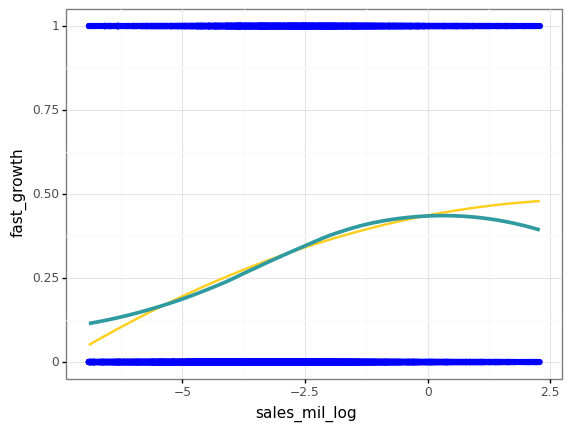

<ggplot: (8775636505483)>

In [37]:
# The bigger the sale, the lower the probability that the company will not exit after two years
ggplot(data, aes(x = 'sales_mil_log', y = 'fast_growth')) + geom_point(
    color = 'blue') + geom_smooth(
    method='lm', formula='y ~ x + I(x**2)',  color=color[3], se = False) + geom_smooth(
    method = 'loess', color=color[4], se = False, size=1.5, span=0.9) + labs(
    x='sales_mil_log', y='fast_growth'
) + theme_bw()

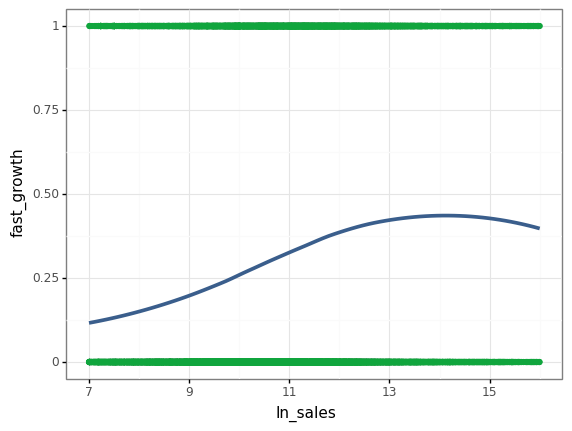

<ggplot: (8775700540109)>

In [38]:
# Within a certain range, the greater the increase in sales, 
# the lower the probability of the company exiting after two years
ggplot(data, aes(x = 'ln_sales', y = 'fast_growth')) + geom_point(
    color=color[1]) + geom_smooth(
    method = 'loess', color=color[0], se = False, size=1.5, span=0.9) + labs(
    x='ln_sales', y='fast_growth') + scale_x_continuous(
    limits=(7, 16), breaks = seq(7, 20, by = 2)
) + theme_bw() 

In [39]:
# no more imputation, drop obs if key vars missing
data = data.dropna(subset = ['liq_assets_bs', 'foreign', 'ind'])

In [40]:
# drop missing
data = data.dropna(subset = ['age', 'foreign', 'material_exp_pl', 'm_region_loc'])
data['age'].describe()

count    18883.000000
mean         9.045491
std          7.132427
min          0.000000
25%          3.000000
50%          7.000000
75%         15.000000
max         62.000000
Name: age, dtype: float64

In [41]:
# drop unused factor levels
for col in data.select_dtypes(include=['category']).columns:
    data[col] = data[col].cat.remove_unused_categories()

In [42]:
data.to_csv('bisnode_firms_clean.csv',index=False)

# Predicting fast growing firms

In [43]:
data = pd.read_csv('bisnode_firms_clean.csv')

In [44]:
# show the columns of missing value
na_filter=data.isna().sum()
na_filter[na_filter > 0].index

Index(['exit_year', 'birth_year', 'exit_date'], dtype='object')

# Define helper functions

In [45]:
def regression_results(y_true, y_pred):
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    
def coef_matrix(X, model):

    coef_matrix = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(model.coef_))], axis = 1)
    coef_matrix.columns = ['variable', 'coefficient']
    coef_matrix = coef_matrix.append({'variable': 'Intercept', 'coefficient': np.asscalar(model.intercept_)}, ignore_index=True)
    return(coef_matrix)

def cv_summary(lambdas, C_values, model):
    d = {'lambdas': lambdas, 'C_values': C_values, 'mean_cv_score': model.scores_[1].mean(axis = 0)}
    return(pd.DataFrame(data=d))

def create_roc_plot(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    all_coords = pd.DataFrame({
        'fpr': fpr,
        'tpr': tpr,
        'thresholds': thresholds
    })
    
    plot = ggplot(all_coords, aes(x = 'fpr', y = 'tpr')) \
        + geom_line(color=color[0], size = 0.7) \
        + geom_area(position = 'identity', fill = 'mediumaquamarine', alpha = 0.3) \
        + xlab("False Positive Rate (1-Specifity)") \
        + ylab("True Positive Rate (Sensitivity)") \
        + geom_abline(intercept = 0, slope = 1,  linetype = "dotted", color = "black") \
        + scale_y_continuous(limits = (0, 1), breaks = seq(0, 1, .1), expand = (0, 0.01)) \
        + scale_x_continuous(limits = (0, 1), breaks = seq(0, 1, .1), expand = (0.01, 0)) \
        + theme_bw()
    return(plot)

def sigmoid_array(x):
    return(1 / (1 + np.exp(-x)))

def generate_fold_prediction(model, X, fold, param_index):
    fold_coef = model.coefs_paths_[1][fold,param_index,:]
    return(sigmoid_array(np.dot(X, np.transpose(fold_coef)[:-1]) +  np.transpose(fold_coef)[-1]))

def create_loss_plot(all_coords, optimal_threshold, curr_exp_loss):
    all_coords_copy = all_coords.copy()
    all_coords_copy['loss'] = (all_coords_copy.false_pos*FP + all_coords_copy.false_neg*FN)/all_coords_copy.n
    
    t = optimal_threshold
    l = curr_exp_loss
    
    plot = ggplot(all_coords_copy, aes(x = 'thresholds', y = 'loss')) + \
        geom_line(color=color[0], size=0.7) + \
        scale_x_continuous(breaks = seq(0, 1.1, by = 0.1)) + \
        coord_cartesian(xlim=(0,1))+ \
        geom_vline(xintercept = t , color = color[0] ) + \
        annotate(geom = "text", x = t - 0.01, y= max(all_coords_copy.loss) - 0.4,
                 label="best threshold: " + str(round(t,2)),
                 colour=color[1], angle=90, size = 7) +\
        annotate(geom = "text", x = t + 0.06, y= l,\
                 label= str(round(l, 2)), size = 7) +\
        theme_bw()
    return(plot)


def create_roc_plot_with_optimal(all_coords, optimal_threshold):
    all_coords_copy = all_coords.copy()
    all_coords_copy['sp'] = all_coords_copy.true_neg/all_coords_copy.neg
    all_coords_copy['se'] = all_coords_copy.true_pos/all_coords_copy.pos
    
    best_coords = all_coords_copy[all_coords_copy.thresholds == optimal_threshold]
    sp = best_coords.sp.values[0]
    se = best_coords.se.values[0]

    plot = ggplot(all_coords_copy, aes(x = 'sp', y = 'se')) +\
        geom_line(color=color[0], size=0.7) +\
        scale_y_continuous(breaks = seq(0, 1.1, by = 0.1)) +\
        scale_x_reverse(breaks = seq(0, 1.1, by = 0.1)) +\
        geom_point(data = pd.DataFrame({'sp': [sp], 'se': [se]})) +\
        annotate(geom = "text", x = sp, y = se + 0.03,
                 label = str(round(sp, 2)) + ', ' + str(round(se, 2)), size = 7) +\
        theme_bw()
    return(plot)

# Define variable sets

In [46]:
rawvars = ["curr_assets", "curr_liab", "extra_exp", "extra_inc", "extra_profit_loss", "fixed_assets",
              "inc_bef_tax", "intang_assets", "inventories", "liq_assets", "material_exp", "personnel_exp",
              "profit_loss_year", "sales", "share_eq", "subscribed_cap"]
qualityvars = ["balsheet_flag", "balsheet_length", "balsheet_notfullyear"]
engvar = ["total_assets_bs", "fixed_assets_bs", "liq_assets_bs", "curr_assets_bs",
            "share_eq_bs", "subscribed_cap_bs", "intang_assets_bs", "extra_exp_pl",
            "extra_inc_pl", "extra_profit_loss_pl", "inc_bef_tax_pl", "inventories_pl",
            "material_exp_pl", "profit_loss_year_pl", "personnel_exp_pl"]
engvar2 = ["extra_profit_loss_pl_quad", "inc_bef_tax_pl_quad",
             "profit_loss_year_pl_quad", "share_eq_bs_quad"]
engvar3=[]
for col in data.columns:
    if col.endswith('flag_low') or col.endswith('flag_high') or col.endswith('flag_error') or col.endswith('flag_zero'):
        engvar3.append(col)

d1 = []
hr = ["female", "ceo_age", "flag_high_ceo_age", "flag_low_ceo_age",
        "flag_miss_ceo_age", "ceo_count", "labor_avg_mod",
        "flag_miss_labor_avg", "foreign_management"]

In [47]:
#Creat dummy columns from category variables and drop first level
ind2_catmat = patsy.dmatrix("0 + C(ind2_cat)",data, return_type="dataframe")
ind2_catmat = ind2_catmat.drop(['C(ind2_cat)[26.0]'], axis=1)

m_region_locmat = patsy.dmatrix("0 + C(m_region_loc)",data, return_type="dataframe")
m_region_locmat = m_region_locmat.drop(['C(m_region_loc)[Central]'], axis=1)

urban_mmat = patsy.dmatrix("0 + C(urban_m)",data, return_type="dataframe")
urban_mmat = urban_mmat.drop(['C(urban_m)[1.0]'], axis=1)

In [48]:
# Define X1
basevars = data[["sales_mil_log", "sales_mil_log_sq"]]
X1 = pd.concat([basevars, ind2_catmat], axis=1)
# Define X2
X2additional_vars = data[["fixed_assets_bs", "share_eq_bs","curr_liab_bs", "curr_liab_bs_flag_high", \
                          "curr_liab_bs_flag_error",  "age", "foreign_management"]]
X2 = pd.concat([X1, X2additional_vars], axis=1)
# Define X3
firm = pd.concat([data[["age", "age2", "new"]], ind2_catmat, m_region_locmat, urban_mmat], axis=1)
X3 = pd.concat([data[["sales_mil_log", "sales_mil_log_sq"] + engvar + d1], firm], axis=1)
# Define X4
X4 = pd.concat([data[["sales_mil_log", "sales_mil_log_sq"] + engvar + d1 \
                                 + engvar2 + engvar3 + hr + qualityvars], firm], axis=1)

In [49]:
# Define X5
#Creat matrix for interactions1 variables
int1mat = patsy.dmatrix("0 + C(ind2_cat):age + C(ind2_cat):age2 + \
                + C(ind2_cat):sales_mil_log + C(ind2_cat):ceo_age + C(ind2_cat):foreign_management \
                + C(ind2_cat):female + C(ind2_cat):C(urban_m) + C(ind2_cat):labor_avg_mod", data, return_type="dataframe")
#Drop first level to get k-1 dummies out of k categorical levels 
for col in int1mat.columns:
    if col.startswith('C(ind2_cat)[26.0]') or col.endswith('C(urban_m)[1.0]'):
        int1mat = int1mat.drop([col], axis=1)
        
#Creat matrix for interactions2 variables        
int2mat = patsy.dmatrix("0 + sales_mil_log:age + sales_mil_log:female + sales_mil_log:profit_loss_year_pl \
                + sales_mil_log:foreign_management", data, return_type="dataframe")
X5 = pd.concat([X4, int1mat, int2mat], axis=1)

In [50]:
# Define rfvars for RF (no interactions, no modified features)
rfvars = X5.copy()

In [51]:
# Define rfvars for RF (no interactions, no modified features)
gbmvars = X5.copy()

In [52]:
y = data['fast_growth']

## Separate train and holdout data

In [53]:
index_train, index_holdout= train_test_split(
    data.index.values, train_size=round(0.8*len(data.index)), random_state=42)

y_train = y.iloc[index_train]
y_holdout = y.iloc[index_holdout]

In [54]:
print('Total')
print(data['fast_growth'].value_counts(normalize=True))
print('Train')
print(data.iloc[index_train]['fast_growth'].value_counts(normalize=True))
print('Holdout')
print(data.iloc[index_holdout]['fast_growth'].value_counts(normalize=True))

Total
0    0.689509
1    0.310491
Name: fast_growth, dtype: float64
Train
0    0.688071
1    0.311929
Name: fast_growth, dtype: float64
Holdout
0    0.695261
1    0.304739
Name: fast_growth, dtype: float64


 ## PART I - PREDICT PROBABILITIES

In [55]:
# specify cross-validation method
k = KFold(n_splits=5, shuffle=True, random_state=42)

## Train logit models

In [56]:
# no regularisation needed so setting the paremeter to very high value
C_value_logit=[1e20]

In [57]:
# Train Logit Models ----------------------------------------------
logit_model_vars = [X1.iloc[index_train], X2.iloc[index_train], X3.iloc[index_train], X4.iloc[index_train], X5.iloc[index_train]]

logit_models = dict()
CV_RMSE_folds = dict()

for i in range(len(logit_model_vars)):
    LRCV_brier = LogisticRegressionCV(Cs=C_value_logit, cv=k, refit=True, scoring='neg_brier_score', 
                            solver="newton-cg", tol=1e-7, random_state=42)
    logit_models['X'+str(i+1)] = LRCV_brier.fit(logit_model_vars[i], y_train)
    # Calculate RMSE on test for each fold
    CV_RMSE_folds['X'+str(i+1)] = np.sqrt(-1*(logit_models['X'+str(i+1)].scores_[1])).tolist()

## PART I
## No loss fn

In [58]:
# Calculate AUC for each folds --------------------------------
CV_AUC_folds = dict()

#refit logit models with AUC so we have AUC values for the same cv split
for i in range(len(logit_model_vars)):
    LRCV_auc = LogisticRegressionCV(Cs=C_value_logit, cv=k, refit=True, scoring='roc_auc', 
                            solver="newton-cg", tol=1e-7, random_state=42)
    LRCV_auc_fit = LRCV_auc.fit(logit_model_vars[i], y_train)
    # Calculate AUC on test for each fold
    CV_AUC_folds['X'+str(i+1)] = LRCV_auc_fit.scores_[1][:,0].tolist()

In [59]:
# For each model: average RMSE and average AUC for models ----------------------------------
CV_RMSE = dict()
CV_AUC = dict()
nvars = dict()

for key in logit_models:
    CV_RMSE[key] = np.mean(CV_RMSE_folds[key])
    CV_AUC[key] = np.mean(CV_AUC_folds[key])
    
for key in logit_models:
    nvars[key] = logit_models[key].n_features_in_

In [60]:
# We have 5 logit models. For each we have a 5-CV RMSE and AUC.
# We pick our preferred model based on that. -----------------------------------------------
logit_summary1 = np.transpose(pd.DataFrame.from_dict([nvars,CV_RMSE,CV_AUC], orient='columns'))
logit_summary1.columns = ['Number of predictors', 'CV RMSE', 'CV AUC']

In [61]:
logit_summary1

,Number of predictors,CV RMSE,CV AUC
X1,9.0,0.454952,0.617490
X2,16.0,0.454116,0.625344
X3,31.0,0.428144,0.737879
X4,74.0,0.429052,0.735499
X5,141.0,0.426740,0.741177


In [62]:
# Take best model and estimate RMSE on holdout  -------------------------------------------

best_model = logit_models['X5']
best_model_X_holdout = X5.iloc[index_holdout]

logit_predicted_probabilities_holdout = best_model.predict_proba(best_model_X_holdout)[:,1]
best_rmse_holdout = np.sqrt(metrics.mean_squared_error(y_holdout, logit_predicted_probabilities_holdout))
round(best_rmse_holdout, 3)

0.422

In [63]:
# discrete ROC (with thresholds in steps) on holdout -------------------------------------------------
thresholds = seq(0.05, 0.8, by = 0.01)
cm = dict()
true_positive_rates = []
false_positive_rates = []
holdout_prediction = []
for thr in thresholds:
    holdout_prediction = np.where(logit_predicted_probabilities_holdout < thr, 0, 1)
    cm_thr = confusion_matrix(y_holdout, holdout_prediction, labels=[0,1])
    cm[thr] = cm_thr
    tn, fp, fn, tp = cm_thr.ravel()
    true_positive_rates.append(tp/(tp+fn))
    false_positive_rates.append(fp/(fp+tn))

In [64]:
tpr_fpr_for_thresholds = pd.DataFrame(
    {'thresholds': thresholds,
     'true_positive_rates': true_positive_rates,
     'false_positive_rates': false_positive_rates})

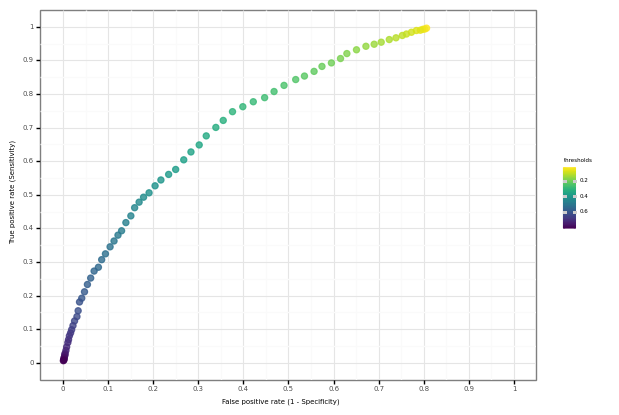

<ggplot: (8775700923621)>

In [65]:
ggplot(tpr_fpr_for_thresholds, aes(x = 'false_positive_rates', y = 'true_positive_rates', color='thresholds'))\
        + labs(x = "False positive rate (1 - Specificity)", y = "True positive rate (Sensitivity)")\
        + geom_point(size=2, alpha=0.8) + scale_color_continuous(trans = 'reverse')\
        + scale_x_continuous(limits=(0,1), breaks = seq(0, 1.01, by = 0.1))\
        + scale_y_continuous(limits=(0,1), breaks = seq(0, 1.01, by = 0.1))\
        + theme_bw()\
        +theme(legend_position="right",
            axis_text=element_text(size=5),
            axis_title=element_text(size=5),
            legend_text = element_text(size = 4),
            legend_title = element_text(size = 4),
            legend_key_size=6)

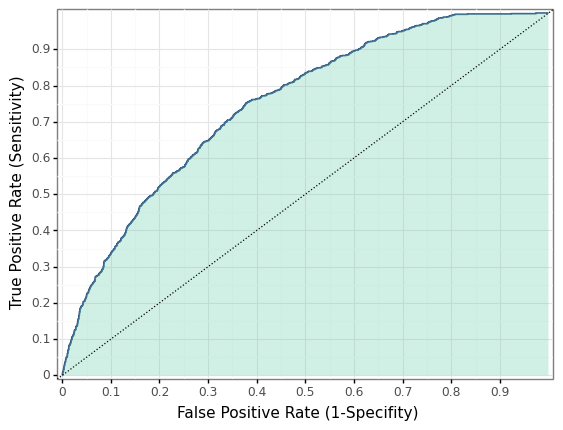

<ggplot: (8775634140525)>

In [66]:
create_roc_plot(y_holdout, logit_predicted_probabilities_holdout)

In [67]:
# Confusion table with different tresholds ----------------------------------------------------------

# fast_growth: the threshold 0.5 is used to convert probabilities to binary classes
logit_class_prediction = best_model.predict(best_model_X_holdout)

values, counts = np.unique(logit_class_prediction.tolist(), return_counts=True)
print(values[0],' (no fast_growth): ',counts[0])
print(values[1],' (fast_growth): ',counts[1])

0  (no fast_growth):  3063
1  (fast_growth):  714


In [68]:
# confusion matrix: summarize different type of errors and successfully predicted cases
# positive = "yes": explicitly specify the positive case
cm_object1 = confusion_matrix(y_holdout, logit_class_prediction, labels=[0,1])
cm1 = pd.DataFrame(cm_object1, 
    index=['Actul no fast_growth', 'Actual fast_growth'], 
    columns=['Predicted no fast_growth', 'Predicted fast_growth'])
cm1

,Predicted no fast_growth,Predicted fast_growth
Actul no fast_growth,2329,297
Actual fast_growth,734,417


In [69]:
# we can apply different thresholds

# 0.5 same as before
holdout_prediction = np.where(logit_predicted_probabilities_holdout < 0.5, 0, 1)
cm_object1b = confusion_matrix(y_holdout, holdout_prediction, labels=[0,1])
cm1b = pd.DataFrame(cm_object1b, 
    index=['Actul no fast_growth', 'Actual fast_growth'], 
    columns=['Predicted no fast_growth', 'Predicted fast_growth'])
cm1b

,Predicted no fast_growth,Predicted fast_growth
Actul no fast_growth,2329,297
Actual fast_growth,734,417


In [70]:
# a sensible choice: mean of predicted probabilities
mean_predicted_fast_growth_prob = np.mean(logit_predicted_probabilities_holdout)
round(mean_predicted_fast_growth_prob, 3)

0.31

In [71]:
holdout_prediction = np.where(logit_predicted_probabilities_holdout < mean_predicted_fast_growth_prob, 0, 1)
cm_object2 = confusion_matrix(y_holdout, holdout_prediction, labels=[0,1])
cm2 = pd.DataFrame(cm_object2, 
    index=['Actul no fast_growth', 'Actual fast_growth'], 
    columns=['Predicted no fast_growth', 'Predicted fast_growth'])
cm2

,Predicted no fast_growth,Predicted fast_growth
Actul no fast_growth,1640,986
Actual fast_growth,294,857


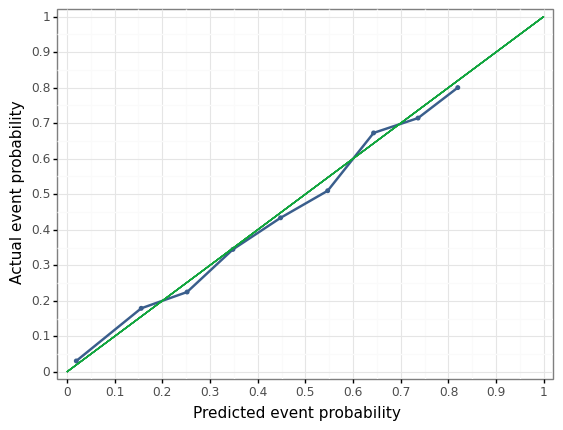

<ggplot: (8775737502019)>

In [72]:
# Calibration curve -----------------------------------------------------------
# how well do estimated vs actual event probabilities relate to each other?

holdout = pd.concat([best_model_X_holdout, y_holdout], axis=1)
holdout["best_logit_no_loss_pred"] = logit_predicted_probabilities_holdout
create_calibration_plot(holdout, file_name = "ch17-figure-1-logit-m4-calibration",\
                        prob_var='best_logit_no_loss_pred', actual_var='fast_growth',\
                        y_lab="Actual event probability", n_bins=10, breaks=None)

# PART II.

# We have a loss function
# PREDICTION WITH LOGIT

In [73]:
# Introduce loss function
# relative cost of of a false negative classification (as compared with a false positive classification)
FP = 1
FN = 5
cost = FN/FP
# the prevalence, or the proportion of cases in the population (n.cases/(n.controls+n.cases))
prevelance = y_train.sum()/len(y_train)

In [74]:
# Draw ROC Curve and find optimal threshold with loss function --------------------------
# The optimal cut-off is the threshold that maximizes the distance to the identity (diagonal) line

best_thresholds_cv = dict()
expected_loss_cv = dict()
fold5_threshold = dict()
fold5_expected_loss = dict()
fold5_all_coords = dict()

for i, model_name in enumerate(logit_models):
    best_thresholds = []
    expected_loss =[]
    if model_name != 'LASSO':
        X = logit_model_vars[i]
        c_index = 0
    else:
        X = normalized_logitvars
        c_index = best_lambda_i
    fold = 0
    for train_index, test_index in k.split(X):
        X_fold = X.iloc[test_index,:]
        y_fold = y_train.iloc[test_index]
        pred_fold = generate_fold_prediction(logit_models[model_name], X_fold, fold, c_index)
        false_pos_rate, true_pos_rate, thresholds = roc_curve(y_fold, pred_fold)
        optimal_threshold = sorted(list(zip(
            np.abs(true_pos_rate + (1 - prevelance)/(cost * prevelance)*(1-false_pos_rate)),\
                                       thresholds)), key=lambda i: i[0], reverse=True)[0][1]
        best_thresholds.append(optimal_threshold)
        threshold_prediction = np.where(pred_fold < optimal_threshold, 0, 1)
        tn, fp, fn, tp = confusion_matrix(y_fold, threshold_prediction, labels=[0,1]).ravel()
        curr_exp_loss = (fp*FP + fn*FN)/len(y_fold)
        expected_loss.append(curr_exp_loss)
        fold = fold+1

    best_thresholds_cv[model_name] = np.mean(best_thresholds)
    expected_loss_cv[model_name] = np.mean(expected_loss)

    # for fold #5
    fold5_threshold[model_name] = optimal_threshold
    fold5_expected_loss[model_name] = curr_exp_loss

    all_coords = pd.DataFrame({
        'false_pos': false_pos_rate*sum(y_fold == 0),
        'true_pos': true_pos_rate*sum(y_fold == 1),
        'false_neg': sum(y_fold == 1) - true_pos_rate*sum(y_fold == 1),
        'true_neg': sum(y_fold == 0) - false_pos_rate*sum(y_fold == 0),
        'pos': sum(y_fold == 1),
        'neg': sum(y_fold == 0),
        'n': len(y_fold),
        'thresholds': thresholds
    })
    
    fold5_all_coords[model_name] = all_coords

In [75]:
logit_summary2 = pd.DataFrame(best_thresholds_cv.items(),columns=['Model', 'Avg of optimal thresholds'])
logit_summary2['Threshold for Fold5'] = fold5_threshold.values()
logit_summary2['Avg expected loss'] = expected_loss_cv.values()
logit_summary2['Expected loss for Fold5'] = fold5_expected_loss.values()

In [76]:
logit_summary2

,Model,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,X1,0.177295,0.190212,0.665829,0.671963
1,X2,0.151930,0.149542,0.673971,0.689176
2,X3,0.151814,0.166796,0.544883,0.540881
3,X4,0.155446,0.185092,0.550511,0.547501
4,X5,0.157049,0.169935,0.539852,0.534922


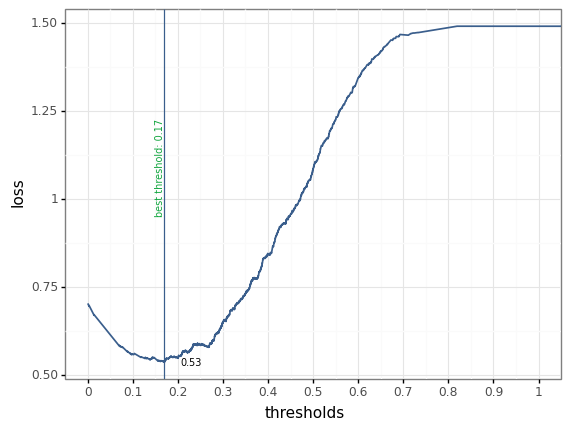

<ggplot: (8775700526761)>

In [77]:
# Create loss plot based on Fold5 in CV 
# select model to plot
model_to_plot = 'X5'
create_loss_plot(fold5_all_coords[model_to_plot], fold5_threshold[model_to_plot], fold5_expected_loss[model_to_plot])

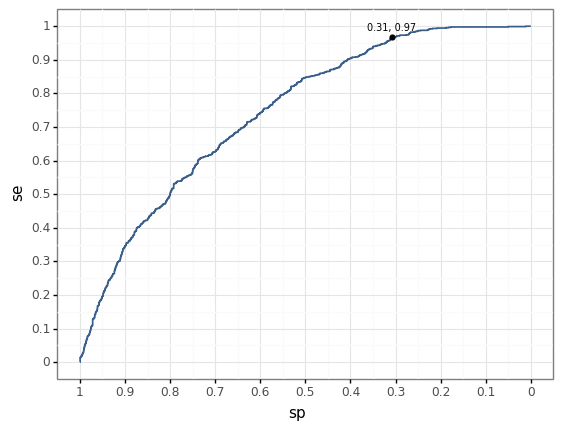

<ggplot: (8775566138097)>

In [78]:
# Create roc plot plot based on Fold5 in CV 
# select model to plot
model_to_plot = 'X5'
create_roc_plot_with_optimal(fold5_all_coords[model_to_plot], fold5_threshold[model_to_plot])

In [79]:
# Pick best model based on average expected loss ----------------------------------
#X5
best_logit_optimal_treshold = best_thresholds_cv["X5"]

# Get expected loss on holdout
holdout_treshold = np.where(logit_predicted_probabilities_holdout < best_logit_optimal_treshold, 0, 1)
tn, fp, fn, tp = confusion_matrix(y_holdout, holdout_treshold, labels=[0,1]).ravel()
expected_loss_holdout = (fp*FP + fn*FN)/len(y_holdout)
round(expected_loss_holdout, 3)

0.562

In [80]:
cm_object3 = confusion_matrix(y_holdout, holdout_treshold, labels=[0,1])
cm3 = pd.DataFrame(cm_object3, 
    index=['Actul no fast_growth', 'Actual fast_growth'], 
    columns=['Predicted no fast_growth', 'Predicted fast_growth'])
cm3

,Predicted no fast_growth,Predicted fast_growth
Actul no fast_growth,799,1827
Actual fast_growth,59,1092


# PREDICTION WITH RANDOM FOREST

In [81]:
rfvars_train = rfvars.iloc[index_train]
rfvars_holdout = rfvars.iloc[index_holdout]

## Probability forest

In [82]:
grid = {'max_features': [5, 6, 7],
        'criterion':['gini'],
        'min_samples_split': [11, 16]} #1 more than in R because here condition for min node size is >= while > in R 

In [83]:
prob_forest = RandomForestClassifier(random_state=42, n_estimators=500, oob_score=True)
prob_forest_grid = GridSearchCV(prob_forest, grid, cv=k, refit='accuracy',
                                scoring = ['accuracy', 'roc_auc', 'neg_brier_score'], n_jobs=-1)

In [84]:
prob_forest_fit = prob_forest_grid.fit(rfvars_train, y_train)

In [85]:
#create CV summary table
cv_accuracy = np.zeros([6])
for i in range(5):
    cv_accuracy = cv_accuracy + prob_forest_fit.cv_results_['split' + str(i) + '_test_accuracy']
cv_accuracy = cv_accuracy/5

cv_auc = np.zeros([6])
for i in range(5):
    cv_auc = cv_auc + prob_forest_fit.cv_results_['split' + str(i) + '_test_roc_auc']
cv_auc = cv_auc/5

cv_rmse = np.zeros([6])
for i in range(5):
    cv_rmse = cv_rmse +np.sqrt(-1*(prob_forest_fit.cv_results_['split' + str(i) + '_test_neg_brier_score'])).tolist()
cv_rmse = cv_rmse/5

prob_forest_cv_results = pd.DataFrame({
    'max_features': prob_forest_fit.cv_results_['param_max_features'],
    'min_samples_split': prob_forest_fit.cv_results_['param_min_samples_split'],
    'cv_accuracy': cv_accuracy,
    'cv_auc': cv_auc,
    'cv_rmse': cv_rmse
})

In [86]:
prob_forest_cv_results

,max_features,min_samples_split,cv_accuracy,cv_auc,cv_rmse
0,5,11,0.725208,0.755991,0.422332
1,5,16,0.723818,0.756269,0.422448
2,6,11,0.726135,0.756153,0.422120
3,6,16,0.726267,0.757813,0.421671
4,7,11,0.728121,0.757566,0.421493
5,7,16,0.728849,0.757669,0.421505


In [87]:
#obtain optimal parameter values
best_mtry = prob_forest_fit.best_params_['max_features']
best_min_node_size = prob_forest_fit.best_params_['min_samples_split']
prob_forest_fit.best_params_

{'criterion': 'gini', 'max_features': 7, 'min_samples_split': 16}

In [88]:
# Get average (ie over the folds) RMSE and AUC ------------------------------------
prob_forest_best_results = prob_forest_cv_results[(prob_forest_cv_results.max_features == best_mtry) & 
                      (prob_forest_cv_results.min_samples_split == best_min_node_size)]
prob_forest_best_results_index = prob_forest_best_results.index.values[0]

CV_RMSE['rf_p'] = prob_forest_best_results.cv_rmse.values[0]
CV_AUC['rf_p'] = prob_forest_best_results.cv_auc.values[0]

In [89]:
# Get fold level RMSE and AUC ------------------------------------

CV_RMSE_folds_rf_p = list()
for i in range(5):
    rmse = np.sqrt(-1*(prob_forest_fit.cv_results_['split' + str(i) + '_test_neg_brier_score'])).tolist()[prob_forest_best_results_index]
    CV_RMSE_folds_rf_p.append(rmse)
CV_RMSE_folds['rf_p'] = CV_RMSE_folds_rf_p

CV_AUC_folds_rf_p = list()
for i in range(5):
    rmse = prob_forest_fit.cv_results_['split' + str(i) + '_test_roc_auc'][prob_forest_best_results_index]
    CV_AUC_folds_rf_p.append(rmse)
CV_AUC_folds['rf_p'] = CV_AUC_folds_rf_p

In [90]:
# Now use loss function and search for best thresholds and expected loss over folds -----
best_thresholds = list()
expected_loss = list()

fold = 0
for train_index, test_index in k.split(rfvars_train):
    X_fold = rfvars_train.iloc[test_index,:]
    y_fold = y_train.iloc[test_index]
    
    X_fold_train = rfvars_train.iloc[train_index,:]
    y_fold_train = y_train.iloc[train_index]
    
    prob_forest_best = RandomForestClassifier(random_state=42, n_estimators=500, oob_score=True,
                    criterion = 'gini', max_features = best_mtry, min_samples_split = best_min_node_size)
    prob_forest_best_fold = prob_forest_best.fit(X_fold_train, y_fold_train)
    pred_fold = prob_forest_best_fold.predict_proba(X_fold)[:,1]

    false_pos_rate, true_pos_rate, threshold = roc_curve(y_fold, pred_fold)
    best_threshold = sorted(list(zip(np.abs(true_pos_rate + (1 - prevelance)/(cost * prevelance)*(1-false_pos_rate)),\
                                       threshold)), key=lambda x: x[0], reverse=True)[0][1]
    best_thresholds.append(best_threshold)
    threshold_prediction = np.where(pred_fold < best_threshold, 0, 1)
    tn, fp, fn, tp = confusion_matrix(y_fold, threshold_prediction, labels=[0,1]).ravel()
    curr_exp_loss = (fp*FP + fn*FN)/len(y_fold)
    expected_loss.append(curr_exp_loss)
    
fold5_threshold_rf = best_threshold
fold5_expected_loss_rf = curr_exp_loss

all_coords_rf = pd.DataFrame({
    'false_pos': false_pos_rate*sum(y_fold == 0),
    'true_pos': true_pos_rate*sum(y_fold == 1),
    'false_neg': sum(y_fold == 1) - true_pos_rate*sum(y_fold == 1),
    'true_neg': sum(y_fold == 0) - false_pos_rate*sum(y_fold == 0),
    'pos': sum(y_fold == 1),
    'neg': sum(y_fold == 0),
    'n': len(y_fold),
    'thresholds': threshold
})

In [91]:
fold5_threshold_rf = best_threshold
fold5_expected_loss_rf = curr_exp_loss

all_coords_rf = pd.DataFrame({
    'false_pos': false_pos_rate*sum(y_fold == 0),
    'true_pos': true_pos_rate*sum(y_fold == 1),
    'false_neg': sum(y_fold == 1) - true_pos_rate*sum(y_fold == 1),
    'true_neg': sum(y_fold == 0) - false_pos_rate*sum(y_fold == 0),
    'pos': sum(y_fold == 1),
    'neg': sum(y_fold == 0),
    'n': len(y_fold),
    'thresholds': threshold
})

In [92]:
expected_loss_cv['rf_p'] = np.mean(expected_loss)
best_thresholds_cv['rf_p'] = np.mean(best_thresholds)

In [93]:
rf_summary = pd.DataFrame(
    {'CV RMSE': [round(CV_RMSE['rf_p'], 3)],
     'CV AUC': [round(CV_AUC['rf_p'], 3)],
     'Avg of optimal thresholds': [round(best_thresholds_cv['rf_p'], 3)],
     'Threshold for Fold5': [round(best_threshold, 3)],
     'Avg expected loss': [round(expected_loss_cv['rf_p'], 3)],
     'Expected loss for Fold5': [round(curr_exp_loss, 3)]})

rf_summary

,CV RMSE,CV AUC,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,0.422,0.758,0.216,0.228,0.537,0.537


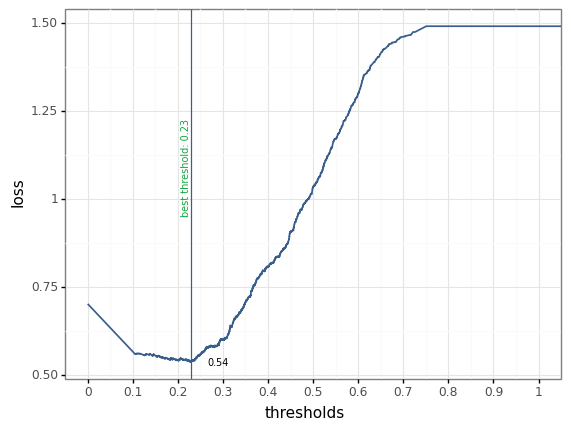

<ggplot: (8775566310605)>

In [94]:
# Create plots based on Fold5 in CV ----------------------------------------------
create_loss_plot(all_coords_rf, fold5_threshold_rf, fold5_expected_loss_rf)

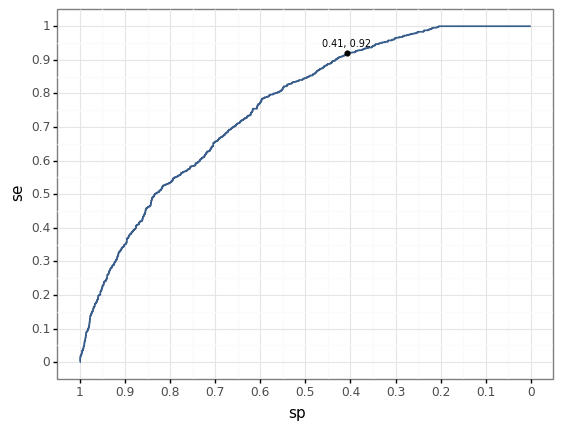

<ggplot: (8775572796772)>

In [95]:
create_roc_plot_with_optimal(all_coords_rf, fold5_threshold_rf)

In [96]:
# Take model to holdout and estimate RMSE, AUC and expected loss ------------------------------------
prob_forest_fit_best = prob_forest_fit.best_estimator_
rf_predicted_probabilities_holdout = prob_forest_fit_best.predict_proba(rfvars_holdout)[:,1]
rmse_rf = np.sqrt(mean_squared_error(y_holdout, rf_predicted_probabilities_holdout))
round(rmse_rf, 3)

0.416

In [97]:
# ROC AUC  on holdout
auc_rf = roc_auc_score(y_holdout, rf_predicted_probabilities_holdout)
round(auc_rf, 3)

0.765

In [98]:
# Get expected loss on holdout
holdout_treshold = np.where(rf_predicted_probabilities_holdout < best_thresholds_cv['rf_p'], 0, 1)
tn, fp, fn, tp = confusion_matrix(y_holdout, holdout_treshold, labels=[0,1]).ravel()
expected_loss_holdout = (fp*FP + fn*FN)/len(y_holdout)
round(expected_loss_holdout, 3)

0.562

In [99]:
cm_object3 = confusion_matrix(y_holdout, holdout_treshold, labels=[0,1])
cm3 = pd.DataFrame(cm_object3, 
    index=['Actul no fast_growth', 'Actual fast_growth'], 
    columns=['Predicted no fast_growth', 'Predicted fast_growth'])
cm3

,Predicted no fast_growth,Predicted fast_growth
Actul no fast_growth,975,1651
Actual fast_growth,94,1057


# PREDICTION WITH GBM

In [100]:
gbmvars_train = gbmvars.iloc[index_train]
gbmvars_holdout = gbmvars.iloc[index_holdout]

In [101]:
grid = {
    "loss":["deviance"],
    "learning_rate": [0.1, 0.15, 0.18],
    "max_depth":[3, 5],
    "criterion": ["friedman_mse"],
    "n_estimators":[50]
    }

In [102]:
prob_gbm = GradientBoostingClassifier(random_state=42, n_estimators=500)
prob_gbm_grid = GridSearchCV(prob_gbm, grid, cv=k, refit='accuracy',
                                scoring = ['accuracy', 'roc_auc', 'neg_brier_score'], n_jobs=-1)

In [103]:
prob_gbm_fit = prob_gbm_grid.fit(gbmvars_train, y_train)

In [104]:
#create CV summary table
cv_accuracy = np.zeros([6])
for i in range(5):
    cv_accuracy = cv_accuracy + prob_gbm_fit.cv_results_['split' + str(i) + '_test_accuracy']
cv_accuracy = cv_accuracy/5

cv_auc = np.zeros([6])
for i in range(5):
    cv_auc = cv_auc + prob_gbm_fit.cv_results_['split' + str(i) + '_test_roc_auc']
cv_auc = cv_auc/5

cv_rmse = np.zeros([6])
for i in range(5):
    cv_rmse = cv_rmse +np.sqrt(-1*(prob_gbm_fit.cv_results_['split' + str(i) + '_test_neg_brier_score'])).tolist()
cv_rmse = cv_rmse/5

prob_gbm_cv_results = pd.DataFrame({
    'learning_rate': prob_gbm_fit.cv_results_['param_learning_rate'],
    'max_depth': prob_gbm_fit.cv_results_['param_max_depth'],
    'cv_accuracy': cv_accuracy,
    'cv_auc': cv_auc,
    'cv_rmse': cv_rmse
})

In [105]:
prob_gbm_cv_results

,learning_rate,max_depth,cv_accuracy,cv_auc,cv_rmse
0,0.1,3,0.722627,0.756058,0.422432
1,0.1,5,0.726334,0.757378,0.421342
2,0.15,3,0.725407,0.757251,0.421672
3,0.15,5,0.726400,0.755794,0.421926
4,0.18,3,0.724613,0.756476,0.421727
5,0.18,5,0.721037,0.754299,0.422881


In [106]:
# obtain optimal parameter values
best_mtry = prob_gbm_fit.best_params_['learning_rate']
best_min_node_size = prob_gbm_fit.best_params_['max_depth']
prob_gbm_fit.best_params_

{'criterion': 'friedman_mse',
 'learning_rate': 0.15,
 'loss': 'deviance',
 'max_depth': 5,
 'n_estimators': 50}

In [107]:
# Get average (ie over the folds) RMSE and AUC ------------------------------------
prob_gbm_best_results = prob_gbm_cv_results[(prob_gbm_cv_results.learning_rate == best_mtry) & 
                      (prob_gbm_cv_results.max_depth == best_min_node_size)]
prob_gbm_best_results_index = prob_gbm_best_results.index.values[0]

CV_RMSE['gbm_p'] = prob_gbm_best_results.cv_rmse.values[0]
CV_AUC['gbm_p'] = prob_gbm_best_results.cv_auc.values[0]

In [108]:
# Get fold level RMSE and AUC ------------------------------------

CV_RMSE_folds_rf_p = list()
for i in range(5):
    rmse = np.sqrt(-1*(prob_gbm_fit.cv_results_['split' + str(i) + '_test_neg_brier_score'])).tolist()[prob_gbm_best_results_index]
    CV_RMSE_folds_rf_p.append(rmse)
CV_RMSE_folds['rf_p'] = CV_RMSE_folds_rf_p

CV_AUC_folds_rf_p = list()
for i in range(5):
    rmse = prob_gbm_fit.cv_results_['split' + str(i) + '_test_roc_auc'][prob_gbm_best_results_index]
    CV_AUC_folds_rf_p.append(rmse)
CV_AUC_folds['rf_p'] = CV_AUC_folds_rf_p

In [109]:
# Now use loss function and search for best thresholds and expected loss over folds -----
best_thresholds = list()
expected_loss = list()

fold = 0
for train_index, test_index in k.split(gbmvars_train):
    X_fold = gbmvars_train.iloc[test_index, :]
    y_fold = y_train.iloc[test_index]

    X_fold_train = gbmvars_train.iloc[train_index, :]
    y_fold_train = y_train.iloc[train_index]

    prob_gbm_best = GradientBoostingClassifier(random_state=42, n_estimators=50, criterion='friedman_mse',
                                                  learning_rate=best_mtry, max_depth=best_min_node_size)
    prob_gbm_best_fold = prob_gbm_best.fit(X_fold_train, y_fold_train)
    pred_fold = prob_gbm_best_fold.predict_proba(X_fold)[:, 1]

    false_pos_rate, true_pos_rate, threshold = roc_curve(y_fold, pred_fold)
    best_threshold = \
    sorted(list(zip(np.abs(true_pos_rate + (1 - prevelance) / (cost * prevelance) * (1 - false_pos_rate)), \
                    threshold)), key=lambda x: x[0], reverse=True)[0][1]
    best_thresholds.append(best_threshold)
    threshold_prediction = np.where(pred_fold < best_threshold, 0, 1)
    tn, fp, fn, tp = confusion_matrix(y_fold, threshold_prediction, labels=[0, 1]).ravel()
    curr_exp_loss = (fp * FP + fn * FN) / len(y_fold)
    expected_loss.append(curr_exp_loss)

fold5_threshold_gbm = best_threshold
fold5_expected_loss_gbm = curr_exp_loss

all_coords_gbm = pd.DataFrame({
    'false_pos': false_pos_rate * sum(y_fold == 0),
    'true_pos': true_pos_rate * sum(y_fold == 1),
    'false_neg': sum(y_fold == 1) - true_pos_rate * sum(y_fold == 1),
    'true_neg': sum(y_fold == 0) - false_pos_rate * sum(y_fold == 0),
    'pos': sum(y_fold == 1),
    'neg': sum(y_fold == 0),
    'n': len(y_fold),
    'thresholds': threshold
})

In [110]:
fold5_threshold_gbm = best_threshold
fold5_expected_loss_gbm = curr_exp_loss

all_coords_gbm = pd.DataFrame({
    'false_pos': false_pos_rate*sum(y_fold == 0),
    'true_pos': true_pos_rate*sum(y_fold == 1),
    'false_neg': sum(y_fold == 1) - true_pos_rate*sum(y_fold == 1),
    'true_neg': sum(y_fold == 0) - false_pos_rate*sum(y_fold == 0),
    'pos': sum(y_fold == 1),
    'neg': sum(y_fold == 0),
    'n': len(y_fold),
    'thresholds': threshold
})

In [111]:
expected_loss_cv['gbm_p'] = np.mean(expected_loss)
best_thresholds_cv['gbm_p'] = np.mean(best_thresholds)

In [112]:
gbm_summary = pd.DataFrame(
    {'CV RMSE': [round(CV_RMSE['gbm_p'], 3)],
     'CV AUC': [round(CV_AUC['gbm_p'], 3)],
     'Avg of optimal thresholds': [round(best_thresholds_cv['gbm_p'], 3)],
     'Threshold for Fold5': [round(best_threshold, 3)],
     'Avg expected loss': [round(expected_loss_cv['gbm_p'], 3)],
     'Expected loss for Fold5': [round(curr_exp_loss, 3)]})

gbm_summary

,CV RMSE,CV AUC,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,0.422,0.756,0.145,0.144,0.534,0.525


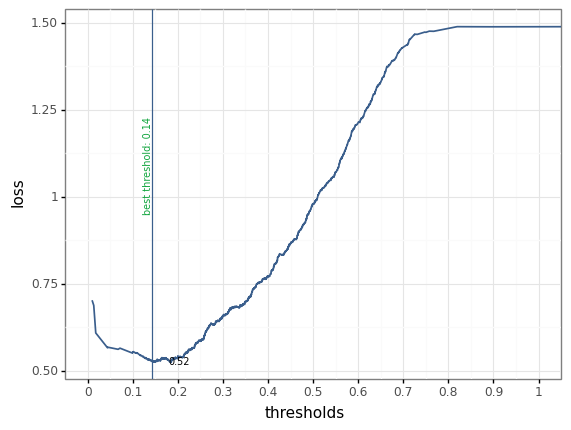

<ggplot: (8775567762993)>

In [113]:
# Create plots based on Fold5 in CV ----------------------------------------------
create_loss_plot(all_coords_gbm, fold5_threshold_gbm, fold5_expected_loss_gbm)

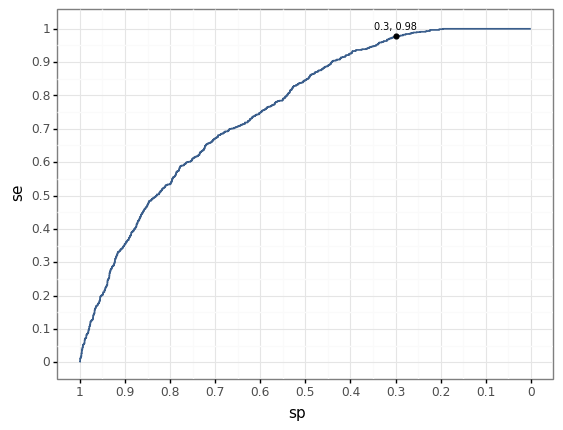

<ggplot: (8775637468465)>

In [114]:
create_roc_plot_with_optimal(all_coords_gbm, fold5_threshold_gbm)

In [115]:
# Take model to holdout and estimate RMSE, AUC and expected loss ------------------------------------
prob_gbm_fit_best = prob_gbm_fit.best_estimator_
gbm_predicted_probabilities_holdout = prob_gbm_fit_best.predict_proba(gbmvars_holdout)[:,1]
rmse_gbm = np.sqrt(mean_squared_error(y_holdout, gbm_predicted_probabilities_holdout))
round(rmse_gbm, 3)

0.416

In [116]:
# ROC AUC on holdout
auc_gbm = roc_auc_score(y_holdout, gbm_predicted_probabilities_holdout)
round(auc_gbm, 3)

0.764

In [117]:
# Get expected loss on holdout
holdout_treshold = np.where(gbm_predicted_probabilities_holdout < best_thresholds_cv['gbm_p'], 0, 1)
tn, fp, fn, tp = confusion_matrix(y_holdout, holdout_treshold, labels=[0,1]).ravel()
expected_loss_holdout = (fp*FP + fn*FN)/len(y_holdout)
round(expected_loss_holdout, 3)

0.547

In [118]:
cm_object3 = confusion_matrix(y_holdout, holdout_treshold, labels=[0,1])
cm3 = pd.DataFrame(cm_object3, 
    index=['Actul no fast_growth', 'Actual fast_growth'], 
    columns=['Predicted no fast_growth', 'Predicted fast_growth'])
cm3

,Predicted no fast_growth,Predicted fast_growth
Actul no fast_growth,781,1845
Actual fast_growth,44,1107


## Final results

In [119]:
nvars['rf_p'] = len(rfvars.columns)
nvars['gbm_p'] = len(gbmvars.columns)

In [120]:
summary_results = pd.DataFrame({"Model": list(nvars.keys()),
                              "Number of predictors": list(nvars.values()),
                              "CV RMSE": list(CV_RMSE.values()),
                              "CV AUC": list(CV_AUC.values()),
                              "CV threshold": list(best_thresholds_cv.values()),
                              "CV expected Loss": list(expected_loss_cv.values())
                               })

In [121]:
summary_results

,Model,Number of predictors,CV RMSE,CV AUC,CV threshold,CV expected Loss
0,X1,9,0.454952,0.617490,0.177295,0.665829
1,X2,16,0.454116,0.625344,0.151930,0.673971
2,X3,31,0.428144,0.737879,0.151814,0.544883
3,X4,74,0.429052,0.735499,0.155446,0.550511
4,X5,141,0.426740,0.741177,0.157049,0.539852
5,rf_p,141,0.421505,0.757669,0.216233,0.536542
6,gbm_p,141,0.421926,0.755794,0.145089,0.534027
